# Recording tawny owls (*Strix aluco*)

## Abstract
Nightly recording sessions require planning. Tawny owls present an interesting test case for planning a nightly recording session, as tawny owls are common in their area of distribution, and their calls can be identified unambiguously. A data set of audio observations was obtained from xeno-canto and examined along three variables that can be predicted: the time of year (month), the hour of the day, and the moon phase. 

It was found that tawny owl vocalizations can be heard throughout the year, but have been maily recorded from February to October, with a peak in June. Hooting can be heard throughout the year, with a peak number of recordings in March-April and June. 

Tawny owl vocalizations have been recorded from 19 until 7 hours. Nevertheless, there is a clear peak in recordings around 23 hours, therefore tawny owls have been recorded mostly after sunset, rather than before sunrise. 

Moon phase appears to have no influence upon the distribution of tawny owl vocalizations. 

It should be noted however, that the data obtained from xeno-canto is likely biased. The avalability of recordists is most certainly skewed towrds daytime recordings, and the availability of recordists throughout the year cannot be assumed to be constant. No attempt was made to correct this bias. Based on these preliminary results, it is however possible to plan nightly recording sessions to try to fill the gaps in recording times.

Keywords: bioacoustics, nocturnal behaviour.

## Data
Audio observations were downloaded from xeno-canto.org on 11 August 2019: [data/xeno-canto-strix-aluco.csv](data/xeno-canto-strix-aluco.csv). This data set contains 1000 observations (Xeno-canto contributors, 2019).  Data was cleaned using Openrefine. Data was cleaned by removing observations without valid month or hour details. To simplify calculations, only observations within the CET time zone were kept. The cleaned-up data is the comma-separated file [data/xeno-canto-strix-aluco-clean.csv](data/xeno-canto-strix-aluco-clean.csv). 

A Openrefine installation is provided as a Docker container and can be accessed on `http://localhost:3333`. The Openrefine script used is in [data/openrefine_facets.txt](data/openrefine_facets.txt). For details on how to apply a script to data see "The Carpentries" (2019).

In [1]:
## Data file
data_file <- "./data/xeno-canto-strix-aluco-clean.csv"
## read the data. One row per observation.
clean <- read.table(data_file, header=TRUE, sep=",")
#head(clean)

cat("The cleaned-up data set has", nrow(clean), "entries.")

# make a second data set, with only the observations tagged as 'song'
song <- data.frame()
for (i in 1:nrow(clean)) {
    if (!grepl('song', clean[i, 'Songtype'])) next
    song<-rbind(song, clean[i,])
}

cat("The song data set has", nrow(song), "entries.")

The cleaned-up data set has 602 entries.The song data set has 257 entries.

## Analysis

### Month data
The month data was bootstrapped 100 times, using random sampling with replacement (Canty and Ripley, 2019; Davison and Hinkley, 1997).

In [2]:
library(boot)

# get a list of months, from the clean data set
getMonth <- function(x) as.numeric( strftime( as.Date(x),"%m") )
dates_all <- as.data.frame(clean[, 'Date'])
clean$months <- apply(dates_all, 2, getMonth)

# get a list of months, from the song data set
dates_song <- as.data.frame(song[, 'Date'])
song$months <- apply(dates_song, 2, getMonth)

# apply bootstrap
bootstrap_dataframe <- function(inputdata, smpnum) {
    allsamples <- data.frame(matrix(0, nrow = length(inputdata), ncol = smpnum))
    for (i in 1:smpnum) {
        sample(inputdata, length(inputdata), replace=TRUE)
        allsamples[,i] <- sample(inputdata, length(inputdata), replace=TRUE)
    }
    return(allsamples)
}

## sample the month data 100x
smpnum = 100
month_allsamples<-bootstrap_dataframe(clean$months, smpnum)
#month_allsamples
month_songsamples<-bootstrap_dataframe(song$months, smpnum)
#month_songsamples

The bootstrapped data was aggregated by month of the year, a column for each bootstrapped sample and a row for each month. 

In [3]:
## for each column in allsamples (the bootstrapped data), 
## count the values aggregated by integer steps between val_min and val_max
aggregate<-function(allsamples, val_min, val_max, smpnum) {
    aggvalues <- data.frame(matrix(0, nrow = val_max - val_min + 1, ncol = smpnum))
    for(i in 1:smpnum) {
        ## make an empty vector of length val_range
        vals <- vector('integer', val_max - val_min + 1)
        ## count values per month
        perstep = table(allsamples[,i])
        for(j in 1:nrow(perstep)) { 
            vi <- as.numeric(row.names(perstep)[j])
            if (val_min == 0) vi = vi + 1 # needed as table rows index starts at 1
            val <- perstep[[j]]
            vals[vi] <- val
        }
        aggvalues[,i] = vals
    }
    return(aggvalues)
}

month_allvalues<-aggregate(month_allsamples, 1, 12, smpnum)
#month_allvalues
month_songvalues<-aggregate(month_songsamples, 1, 12, smpnum)
#month_songvalues

The mean and standard deviation of the number of observations per month were computed. The result is a 12 x 4 data frame with one row per month and columns for the month number (month), the mean count of observations per month (mean), the standard derivation (sd) and the confidence interval (ci).

In [4]:
## get mean and sd per month
get_means_sd <- function(values, val_min, val_max) {
    means <- data.frame(matrix(0, nrow = val_max - val_min + 1, ncol = 4))
    names(means) <- c("range","mean", "sd","ci")
    means[,1] <- list(val_min:val_max)
    for(i in val_min:val_max) {
        if (val_min == 0) i = i + 1 # needed as table rows index starts at 1
        ## mean
        means[i,2] <- mean(as.numeric(values[i,]))
        ## sd
        sdi <- sd(as.numeric(values[i,]))
        means[i,3] <- sdi
        ## ci
        n <- length(values[i,])
        means[i,4] <- qnorm(0.975)*sdi/sqrt(n)
    }
    return(means)
}
month_allmeans <- get_means_sd(month_allvalues, 1, 12)
cat("All observations")
month_allmeans
month_songmeans <- get_means_sd(month_songvalues, 1, 12)
cat("Only observations tagged 'song'")
month_songmeans

All observations

range mean  sd       ci       
1   1    21.22 4.842113 0.9490368
2   2    55.11 7.032242 1.3782941
3   3    69.16 7.739078 1.5168315
4   4    60.43 6.739384 1.3208949
5   5    62.78 7.367112 1.4439275
6   6    87.62 7.762614 1.5214445
7   7    50.80 6.483857 1.2708127
8   8    41.71 6.177991 1.2108640
9   9    67.48 7.932136 1.5546702
10 10    45.63 6.691854 1.3115793
11 11    21.57 4.219376 0.8269824
12 12    18.49 4.604554 0.9024760

Only observations tagged 'song'

range mean  sd       ci       
1   1    16.33 3.725574 0.7301990
2   2    31.00 5.199068 1.0189985
3   3    44.98 6.770375 1.3269691
4   4    42.90 6.371496 1.2487902
5   5    14.60 3.811201 0.7469817
6   6    37.29 5.091675 0.9979499
7   7     7.75 2.021975 0.3962999
8   8    14.85 3.801581 0.7450962
9   9    15.81 4.181960 0.8196491
10 10    13.27 3.805512 0.7458666
11 11     6.81 2.894422 0.5672962
12 12    11.41 3.269371 0.6407850

## Hour data
Hour data was rounded by to the nearest hour, then, as with month data, the hour data was bootstrapped 100 times, using random sampling with replacement (Canty and Ripley, 2019; Davison and Hinkley, 1997).

In [5]:
# get a list of times, from the clean data set
clean$times <- as.data.frame(clean[, 'Time'])

# round to full hour
round_hours <- function(x) format(round(strptime(paste("2001-01-01", x), format="%Y-%m-%d %H:%M"), units="hours"), format="%H")
# number of bootstrap samples
spnum<-100

# all calls
rounded_alltimes <- apply(clean$times, 2, round_hours)
rounded_alltimes <- as.numeric(rounded_alltimes[!is.na(rounded_alltimes)])
## sample the hour data 100x
hour_allsamples<-bootstrap_dataframe(rounded_alltimes, spnum)
#hour_allsamples

The bootstrapped data was aggregated by hour of the day, a column for each bootstrapped sample and a row for each hour. 

In [6]:
hour_allvalues<-aggregate(hour_allsamples, 0, 23, spnum)
#hour_allvalues

The mean and standard deviation of the number of observations per hour of the day were computed. The result is a 24 x 4 data frame with one row per month of the day and columns for the hour, the mean count of observations per hour of the day (mean), the standard derivation (sd) and the confidence interval (ci).

In [7]:
hour_allmeans <- get_means_sd(hour_allvalues, 0, 23)
hour_allmeans

range mean  sd        ci       
1   0    59.19 7.6563765 1.5006222
2   1    33.17 5.7420213 1.1254155
3   2    23.89 4.7159626 0.9243117
4   3    18.67 4.0328324 0.7904206
5   4    30.13 5.3985688 1.0581000
6   5    31.91 5.4422496 1.0666613
7   6    32.82 5.6342746 1.1042975
8   7    16.91 4.6146342 0.9044517
9   8     4.63 2.1633074 0.4240005
10  9     0.91 1.0550025 0.2067767
11 10     1.85 1.8278154 0.3582452
12 11     0.99 1.0683226 0.2093874
13 12     0.87 0.8245599 0.1616108
14 13     0.99 1.0395706 0.2037521
15 14     1.18 0.9783515 0.1917534
16 15     0.00 0.0000000 0.0000000
17 16     0.00 0.0000000 0.0000000
18 17     4.22 2.3250068 0.4556930
19 18     6.35 2.3841861 0.4672919
20 19    43.84 6.7863797 1.3301060
21 20    43.37 6.1293383 1.2013282
22 21    55.36 7.4840166 1.4668403
23 22    84.80 7.4399957 1.4582124
24 23    94.95 8.3198376 1.6306582

### Moon phase
Moon phase was computed using the package suncalc (Thieurmel and Elmarhraoui, 2019).

In [8]:
# suncalc is not included in the bioacoustics-notebbok Docker image
# it is installed by the ./install script in the user library directory
library("suncalc", lib="/home/jovyan/library")

dates = as.data.frame(clean[, 'Date'])
#dates_all[,1]
# get a list of moon phases
phases_all<-c()
for(i in 1:nrow(dates)) {
    illu<-getMoonIllumination(date = as.Date(dates[i,1]), keep = "phase")
    if (illu['phase'] < 0.125) {phase<-1} # New Moon 
    else if(illu['phase'] < 0.375) {phase<-2} # First Quarter
    else if(illu['phase'] < 0.625) {phase<-3} # Full Moon
    else if(illu['phase'] < 0.875) {phase<-4} # Last Quarter
    else if(illu['phase'] <= 1.0) {phase<-1} # New Moon
    phases_all<-c(phases_all, phase)
}

#phases_all

Moon illumination was aggregated moon phase, then, as with month data, the moon phase data was bootstrapped 100 times, using random sampling with replacement (Canty and Ripley, 2019; Davison and Hinkley, 1997).

In [9]:
## sample the hour data 100x
smpnum = 100
phase_allsamples<-bootstrap_dataframe(phases_all, smpnum)
#phase_allsamples

The bootstrapped data was aggregated by moon phase, a column for each bootstrapped sample and a row for phase. 

In [10]:
phase_allvalues<-aggregate(phase_allsamples, 1, 4, smpnum)
#phase_allvalues

The mean and standard deviation of the number of observations per moon phase were computed. The result is a 4 x 4 data frame with one row per moon phase and columns for the phase, the mean count of observations per phase (mean), the standard derivation (sd) and the confidence interval (ci).

In [11]:
moon_phases <- c("New Moon", "First Quarter", "Full Moon", "Last Quarter")
phase_allmeans <- get_means_sd(phase_allvalues, 1, 4)
phase_allmeans$range<-as.character(phase_allmeans$range)
for (i in 1:length(moon_phases)) {
    phase_allmeans$range[phase_allmeans$range == i] <- moon_phases[i]
}
phase_allmeans

range         mean   sd        ci      
1 New Moon      155.28  9.761893 1.913296
2 First Quarter 145.18 10.777249 2.112302
3 Full Moon     139.69 10.857846 2.128099
4 Last Quarter  161.85 12.333231 2.417269

## Discussion
The average number of calls by month, by hour of the day and by moon phase can now be plotted using the libaries ggplot2 (Wickham, 2016) and cowplot (Wilke, 2019).

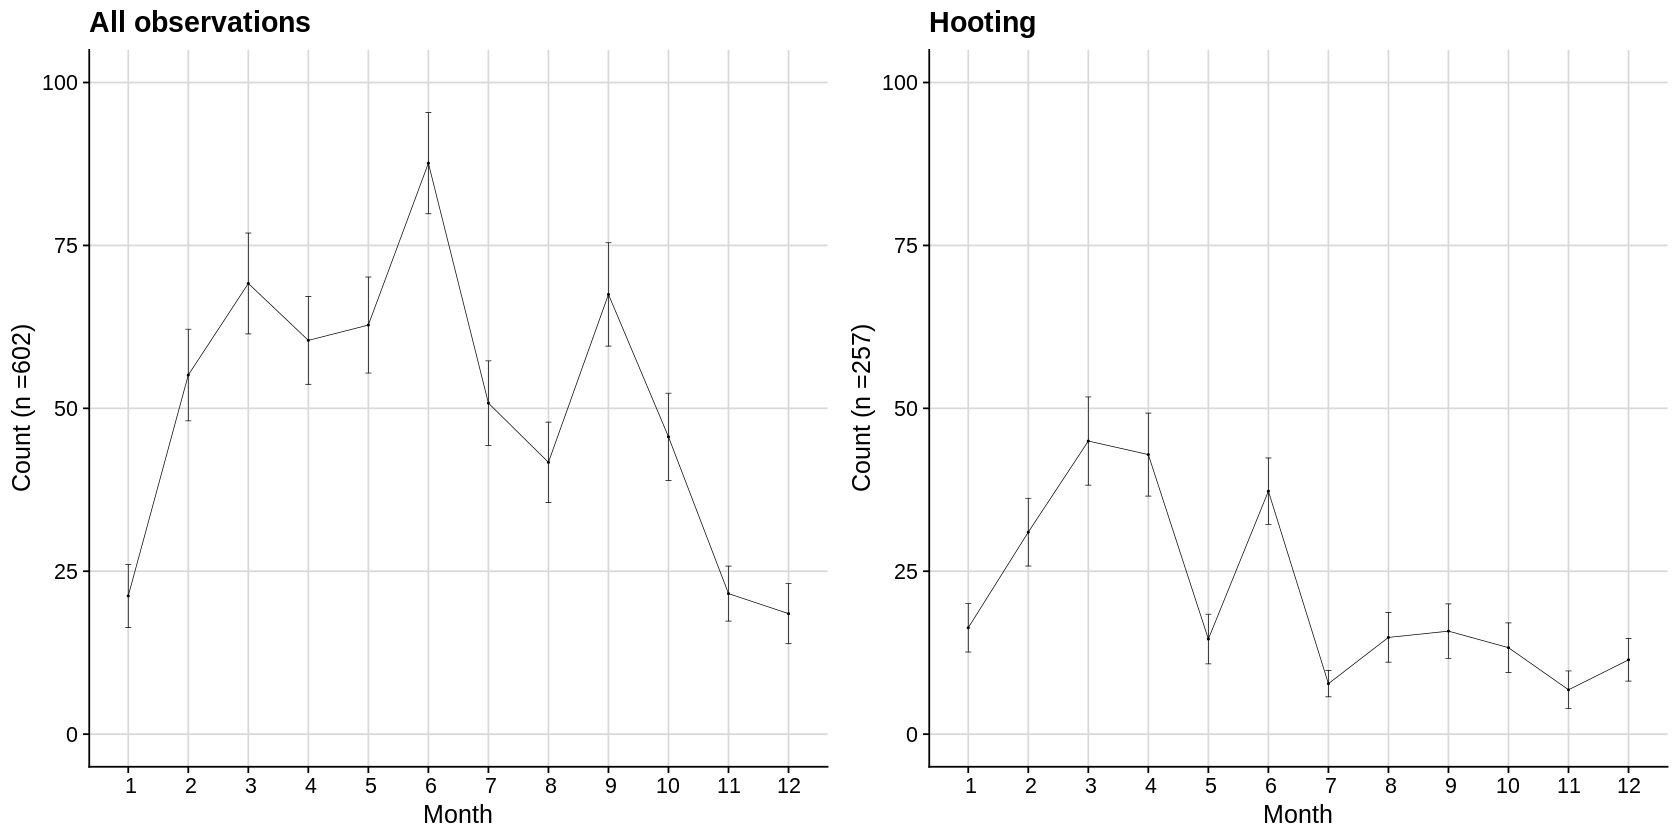

In [13]:
library(ggplot2)
library(cowplot)

## get observation count
n <- nrow(clean)
# thickness of lines
eWidth = 0.2
# font sizes
theme_set(theme_cowplot(font_size=15))
saved <- options(repr.plot.width=14, repr.plot.height=7)

## diagram title
month_title = "Strix aluco average audio observations by month"
## the maximum number of calls displayed on the y-axis, a heuristic to get a decent graph
month_ylimit = 100 
## plot the mean and the sd for the month data
p_months <- ggplot(month_allmeans, aes(x=c(1:12),y=mean)) +
    ggtitle("All observations") +
    geom_point(size=eWidth) +
    geom_line(size=eWidth) +
    geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.1, size=eWidth) +
    scale_y_continuous(limits=c(0,month_ylimit)) +
    scale_x_discrete(name="Month", limits=c(1:12)) +
    ylab( paste( "Count (n =", nrow(clean), ")", sep="" ) ) +
    background_grid(major = 'xy')
#plot_months <- plot(p)

## plot the mean and the sd for the song month data
p_songmonths <- ggplot(month_songmeans, aes(x=c(1:12),y=mean)) +
    ggtitle("Hooting") +
    geom_point(size=eWidth) +
    geom_line(size=eWidth) +
    geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.1, size=eWidth) +
    scale_y_continuous(limits=c(0,month_ylimit)) +
    scale_x_discrete(name="Month", limits=c(1:12)) +
    ylab( paste( "Count (n =", nrow(song), ")", sep="" ) ) +
    background_grid(major = 'xy')
#plot_songmonths <- plot(p_song)

# combine the 2 plots
library(gridExtra, lib="/home/jovyan/library")
aa <- grid.arrange( p_months,  p_songmonths, ncol=2)
plot_months <- aa + scale_y_continuous()

Tawny owl vocalizations can be heard throughout the year, but activity is highest from February to October, with a peak in June. Hooting can be heard throughout the year, with peaks in March-April and June.

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”


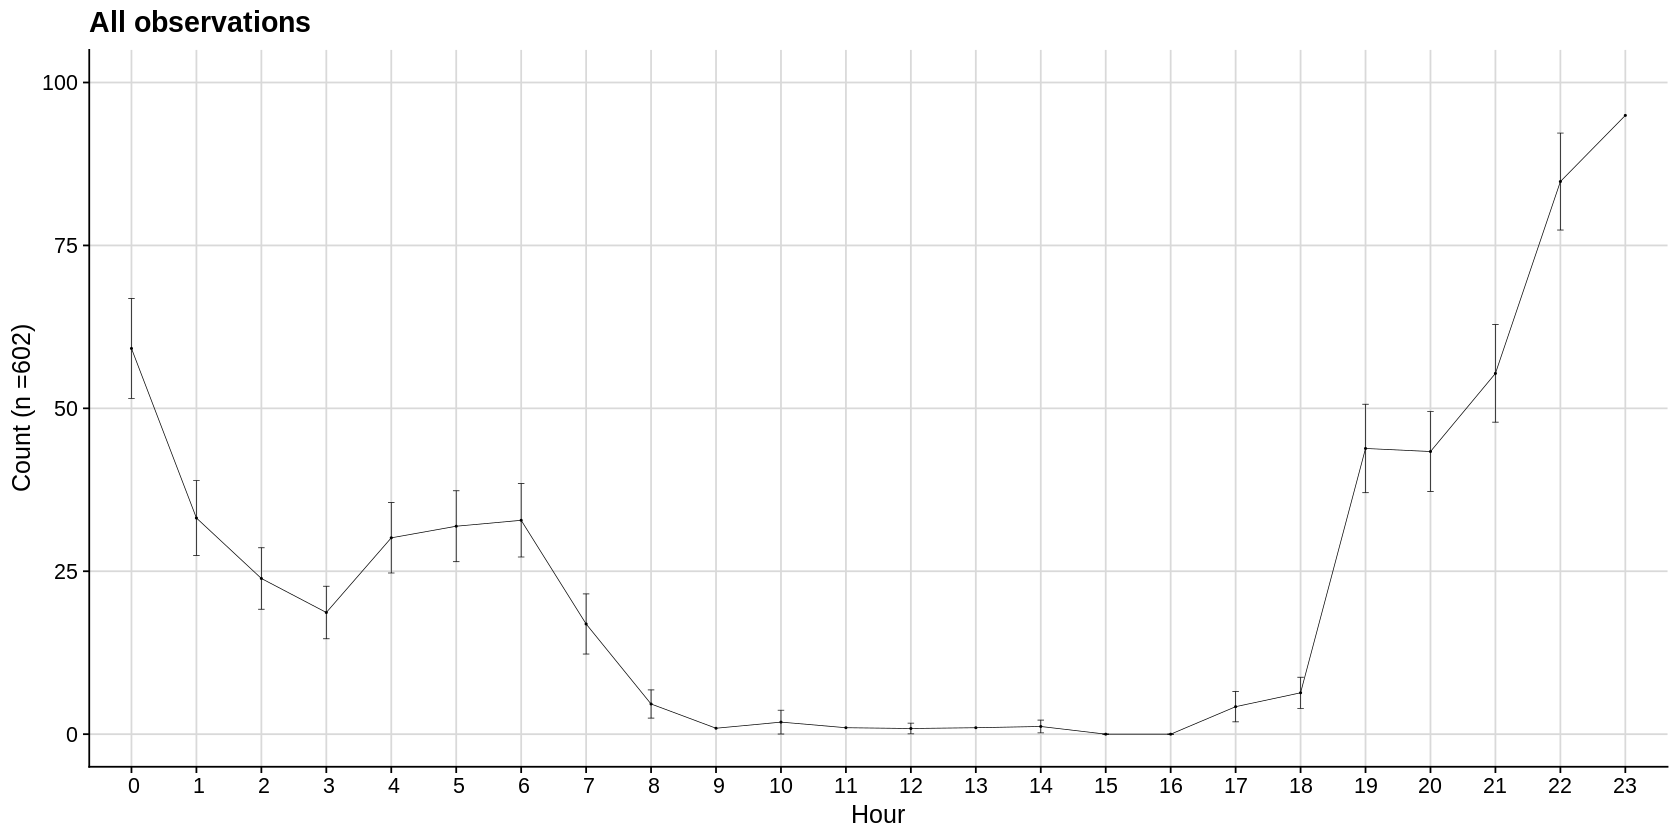

In [14]:
## diagram title
hour_title = "Strix aluco average audio observations by hour of the day"
## the maximum number of calls displayed on the y-axis, a heuristic to get a decent graph
hour_ylimit = 100

## plot the mean and the sd for the hour data
p <- ggplot(hour_allmeans, aes(x=c(0:23),y=mean)) +
    ggtitle("All observations") +
    geom_point(size=eWidth) +
    geom_line(size=eWidth) +
    geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.1, size=eWidth) +
    scale_y_continuous(limits=c(0,hour_ylimit)) +
    scale_x_discrete(name="Hour", limits=c(0:23)) +
    ylab( paste( "Count (n =", n, ")", sep="" ) ) +
    background_grid(major = 'xy')    
plot_hours <- plot(p)

Tawny owl vocalizations have been recorded from 19 until 7 hours. The data is probably biased by the decreased availability of recordists during the night. Nevertheless, there is a clear peak in recordings around 23 hours, therefore tawny owls are mostly active after sunset, rather than before sunrise. 

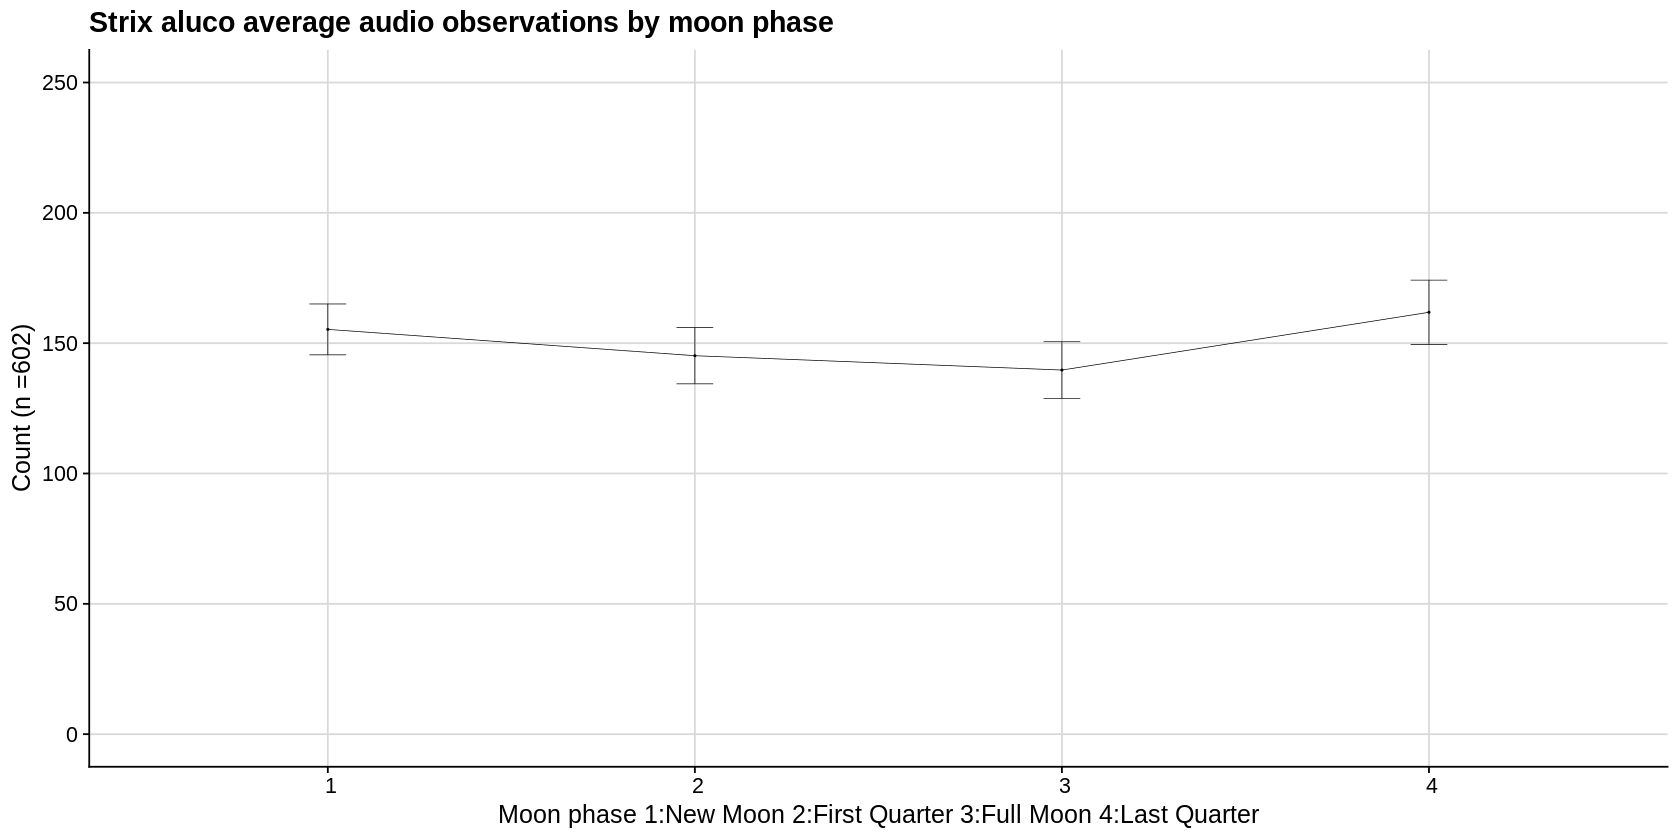

In [15]:
## diagram title
phase_title = "Strix aluco average audio observations by moon phase"
## the maximum number of calls displayed on the y-axis, a heuristic to get a decent graph
phase_ylimit = 250 
## plot the mean and the sd for the moon phase data
p_phase <- ggplot(phase_allmeans, aes(x=c(1:4),y=mean)) +
    ggtitle(phase_title) +
    geom_point(size=eWidth) +
    geom_line(size=eWidth) +
    geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.1, size=eWidth) +
    scale_y_continuous(limits=c(0,phase_ylimit)) +
    scale_x_discrete(name="Moon phase 1:New Moon 2:First Quarter 3:Full Moon 4:Last Quarter", limits=c(0:23)) +
    ylab( paste( "Count (n =", n, ")", sep="" ) ) +
    background_grid(major = 'xy')    
plot_phase <- plot(p_phase)

Moon phase does not influence the distribution of tawny owl vocalizations. 

Restore graphics settings to default and save the plots in the **fig** directory.

In [16]:
# restore graphical settings
theme_set(theme_cowplot())
options(saved)
theme_set(theme_cowplot(font_size=5))
# save plots
out_file <- "./fig/plotMonths.png"
save_plot(out_file, p_months, base_height=2.5)
out_file <- "./fig/plotSongMonths.png"
save_plot(out_file, p_songmonths, base_height=2.5)
out_file <- "./fig/plotHours.png"
save_plot(out_file, plot_hours, base_height=2.5)
out_file <- "./fig/plotPhase.png"
save_plot(out_file, plot_phase, base_height=2.5)
theme_set(theme_cowplot())

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”


## Acknowledgements
I would like to thank the xeno-canto contributors for making their observation data avalable. As this data set has 1000 rows, it is impractical to cite each recordist. Please refer to the [data set](data/xeno-canto-strix-aluco.csv) (Xeno-canto contributors, 2019) for details. Special thanks to Ulf Elman and Alexander Henderson for discussing the topic on the xeno-canto forum (https://www.xeno-canto.org/article/236).

# References

Angelo Canty and Brian Ripley (2019). boot: Bootstrap R (S-Plus) Functions. R package version 1.3-23.

The Carpentries (2019). Data Carpentry - Data Cleaning with OpenRefine for Ecologists, https://datacarpentry.org/OpenRefine-ecology-lesson/04-scripts/index.html (accessed 24.08.2019)

Davison, A. C. & Hinkley, D. V. (1997) Bootstrap Methods and Their Applications. Cambridge University Press, Cambridge. ISBN 0-521-57391-2

Benoit Thieurmel and Achraf Elmarhraoui (2019). suncalc: Compute Sun Position, Sunlight Phases, Moon Position and Lunar Phase. R package version 0.5.0. https://CRAN.R-project.org/package=suncalc

H. Wickham (2016) ggplot2: Elegant Graphics for Data Analysis. Springer-Verlag New York

Claus O. Wilke (2019). cowplot: Streamlined Plot Theme and Plot Annotations for 'ggplot2'. R package version 1.0.0. https://CRAN.R-project.org/package=cowplot

Xeno-canto contributors (2019) Strix aluco, https://www.xeno-canto.org/explore?query=Strix%20aluco (accessed 14.08.2019)